# Tabular - Mutliclass Classification using DNNs
By [Akshaj Verma](https://akshajverma.com/)

This notebook takes you through the implementation of multiclass classification using feedforward networks on the [wine dataset](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) using PyTorch.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv("../../../data/tabular/classification/winequality-red.csv")

## Pre-processing

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
len(df)

1599

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Histogram of output labesls.

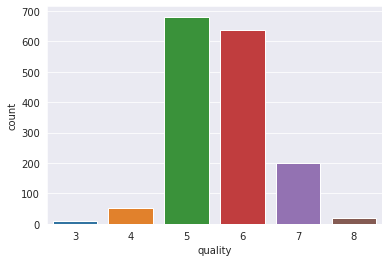

In [7]:
sns.countplot(x = 'quality', data=df)

In [8]:
# quality_ohe = pd.get_dummies(df['quality'], prefix='quality_')
# df = df.join(quality_ohe, how='inner')
# df.drop(labels = 'quality', axis=1, inplace=True)

In [9]:
# PyTorch supports labels starting from 0. That is [0, n]. We need to remap our labels to start from 0.

quality_mapper = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

df['quality'].replace(quality_mapper, inplace=True)

In [10]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

## Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify = y)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Parameters

In [13]:
EPOCHS = 60
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROPOUT = 0.3

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

## Define custom data loader

In [14]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

    
    
train_data = trainData(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))



class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
    
test_data = testData(torch.FloatTensor(X_test))

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

## Define Neural Net Architecture

In [16]:
class multiclassClassification(nn.Module):
    def __init__(self, num_feature, num_class, dropout):
        super(multiclassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, num_class)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.batchnorm3 = nn.BatchNorm1d(16)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        
        x = self.dropout(x)
        
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        
        x = self.dropout(x)

        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        
        x = self.dropout(x)

        
        x = self.layer_out(x)
        
        return x

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
model = multiclassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES, dropout=DROPOUT)
model.to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

multiclassClassification(
  (layer_1): Linear(in_features=11, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Train 

In [19]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [20]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = multi_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 1.89925 | Acc: 0.000
Epoch 002: | Loss: 1.78672 | Acc: 0.000
Epoch 003: | Loss: 1.69186 | Acc: 0.000
Epoch 004: | Loss: 1.61467 | Acc: 5.000
Epoch 005: | Loss: 1.54636 | Acc: 25.000
Epoch 006: | Loss: 1.49654 | Acc: 55.000
Epoch 007: | Loss: 1.43841 | Acc: 55.000
Epoch 008: | Loss: 1.41457 | Acc: 60.000
Epoch 009: | Loss: 1.37363 | Acc: 50.000
Epoch 010: | Loss: 1.31054 | Acc: 90.000
Epoch 011: | Loss: 1.30338 | Acc: 90.000
Epoch 012: | Loss: 1.24611 | Acc: 85.000
Epoch 013: | Loss: 1.24650 | Acc: 90.000
Epoch 014: | Loss: 1.21800 | Acc: 95.000
Epoch 015: | Loss: 1.17217 | Acc: 90.000
Epoch 016: | Loss: 1.17398 | Acc: 95.000
Epoch 017: | Loss: 1.10523 | Acc: 95.000
Epoch 018: | Loss: 1.12580 | Acc: 90.000
Epoch 019: | Loss: 1.10332 | Acc: 90.000
Epoch 020: | Loss: 1.08925 | Acc: 90.000
Epoch 021: | Loss: 1.07948 | Acc: 90.000
Epoch 022: | Loss: 1.06703 | Acc: 95.000
Epoch 023: | Loss: 1.05995 | Acc: 95.000
Epoch 024: | Loss: 1.02092 | Acc: 95.000
Epoch 025: | Loss: 1

## Test

In [21]:
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())

In [22]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Confusion Matrix

In [23]:
confusion_matrix(y_test, y_pred_list)

array([[  0,   0,   2,   0,   0,   0],
       [  0,   1,   9,   1,   0,   0],
       [  0,   2, 106,  28,   0,   0],
       [  0,   0,  48,  76,   4,   0],
       [  0,   0,   2,  25,  13,   0],
       [  0,   0,   0,   3,   0,   0]])

### Classification Report

In [24]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.09      0.14        11
           2       0.63      0.78      0.70       136
           3       0.57      0.59      0.58       128
           4       0.76      0.33      0.46        40
           5       0.00      0.00      0.00         3

    accuracy                           0.61       320
   macro avg       0.38      0.30      0.31       320
weighted avg       0.61      0.61      0.59       320



/home/akshaj/miniconda3/envs/toothless/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
